
# **CONF**

In [1]:
monk_path = 'monk/monks-'
cup_path =  'datasets/ML-CUP22-'

# **UTILS**

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
from numpy.linalg import norm
from sklearn.metrics import make_scorer


def load_cup_data(train=True):

    data_type = "TR" if train else "TS"
    path =cup_path+data_type+'.csv'

    columns = ["id","a1", "a2", "a3", "a4", "a5", "a6", "a7", "a8", "a9", "out1", "out2"]

    df = pd.read_csv(path,names=columns, skiprows=7)
    df = df.drop('id', axis='columns')

    return df.sample(frac=1)

 
def monk_create_df(num, train=True):

    data_type = "train" if train else "test"
    path =monk_path+str(num)+'.'+data_type

    columns = ["id", "output", "a1", "a2", "a3", "a4", "a5", "a6", "monk_id"]
    df = pd.read_csv(path, names=columns, delimiter=" ")

    df = df.drop("id", axis='columns')
    df = df.drop("monk_id", axis='columns')

    return pd.get_dummies(df, columns=df.columns[1:])


def monk_split_data_target(df):

  y = df["Class"]
  x = df.drop("Class", axis=1)
  return x.to_numpy(), y.to_numpy()


def cup_split_data_target(df):

    N = 2
    M = 9

    data = df.iloc[:, : M]
    target_df = df.iloc[:, -N:]
  
    return data, target_df


def np_monk(df, X_type=np.float, Y_type=np.int):
   
    matrix = df.to_numpy()

    X = matrix[:, 1:]
    X = X.astype(X_type)

    Y = matrix[:, 0]
    Y = Y.astype(Y_type)
    Y = Y.reshape(-1, 1)

    return X, Y


def np_cup_TR(df, test=False):
   
    matrix = df.to_numpy()
    # test samples are 20% of all the samples
    test_samples = matrix.shape[0] // 20

    # the first 80%
    dev_set = matrix[:-test_samples]
    # the last 20%
    test_set = matrix[-test_samples:]
    
    X_dev = dev_set[:, :10]
    Y_dev = dev_set[:, 9:]

    X_test = test_set[:, :10]
    Y_test = test_set[:, 9:]

    X_scaler = StandardScaler()
    X_scaler.fit(X_dev)

    if test:
        return X_scaler.transform(X_test), Y_test
    else:
        return X_scaler.transform(X_dev), Y_dev


def mean_euclidian_error_loss(y_true, pred_y):
    if y_true.ndim > 1:
        l2_norms = np.linalg.norm(y_true - pred_y, axis=1)
        return np.mean(l2_norms, axis=0)
    else:
        return np.mean(np.abs(y_true - pred_y))

 
def MEE(x,y,mean=True):
    assert x.shape == y.shape, 'x and y must have same shape'
    length = x.shape[0]
    r = sum([norm(x[i]-y[i]) for i in range(length)])
    return r/length if mean else r       



from sklearn.metrics import make_scorer

custom_mee_scorer = make_scorer(MEE, greater_is_better=False)



def plot_NN_TR_TS(tr_stat, test_stat, name='error'):
    _, ax = plt.subplots()
    ax.plot(tr_stat, label="training")
    ax.plot(test_stat, '--', label="test")
    ax.legend()
    ax.set(xlabel='epoch', ylabel=name)
    ax.set_title(name+' per epoch')
    return ax


def plot_NN_TR_VAL(tr_stat, val_stat, name='error'):
    _, ax = plt.subplots()
    ax.plot(tr_stat, label="training")
    ax.plot(val_stat, '--', label="validation")
    ax.legend()
    ax.set(xlabel='epoch', ylabel=name)
    ax.set_title(name+' per epoch')
    return ax

/var/folders/6m/k3pmzbrs5sq0h_2x7pg04qvc0000gn/T/ipykernel_68242/2199897956.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def np_monk(df, X_type=np.float, Y_type=np.int):
/var/folders/6m/k3pmzbrs5sq0h_2x7pg04qvc0000gn/T/ipykernel_68242/2199897956.py:58: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more deta

# **NN**

In [3]:
import torch
from torch import nn
from torch.linalg import norm
from collections import OrderedDict
from torch.nn import MSELoss


class NN_HyperParameters:
    def __init__(
        self,
        layers,
        lr: float = None,
        beta1: float = None,
        beta2: float = None,
        weight_decay=None,
        mb_size: int = None,
    ):
        self.layers = layers
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.weight_decay = weight_decay
        self.mb_size = mb_size


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.normal_(m.bias)


class NN_module(nn.Module):

    def __init__(self, out_size: int, NN_HP: NN_HyperParameters):
        super().__init__()

        self.NN_HP = NN_HP
        net_topology = OrderedDict()
        layers = NN_HP.layers
        n_layers = len(NN_HP.layers)

        for i in range(n_layers):
            if i != n_layers - 1:
                net_topology[f"fc{i}"] = nn.Linear(layers[i], layers[i + 1])
                net_topology[f"LeakyReLu{i}"] = nn.LeakyReLU()
            else:
                net_topology[f"fc{i}"] = nn.Linear(layers[i], out_size)

        self.net = nn.Sequential(net_topology)
        self.apply(weights_init)


        self.optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.NN_HP.lr,
            betas=(self.NN_HP.beta1, self.NN_HP.beta1),
            weight_decay=self.NN_HP.weight_decay,
        )

        self.loss_f = nn.MSELoss()


def epoch_minibatches(mb_size, X, Y):

    data_size = X.shape[0]
    permutation = torch.randperm(data_size)
    for i in range(0, data_size, mb_size):
        indices = permutation[i : i + mb_size]
        yield (X[indices], Y[indices])


def MEE(x,y,mean=True):

    assert x.shape == y.shape, 'x and y must have same shape'
    length = x.shape[0]
    r = sum([norm(x[i]-y[i]) for i in range(length)])
    r = r.item()
    return r/length if mean else r

# **NN_MONK**

In [4]:
import torch
from torch import nn
from math import ceil

class NN_BinClassifier(NN_module):
    def forward(self, x):
        out = self.net(x)
        return nn.functional.sigmoid(out)


def binary_acc(y_pred, y_test, mean=True):

    y_pred = torch.round(y_pred)
    acc = (y_pred == y_test).sum().item()
    return acc / y_test.shape[0] if mean else acc


def train_NN_monk(model, X_train, Y_train, X_val, Y_val, max_epochs):

    X_train = torch.Tensor(X_train)
    Y_train = torch.Tensor(Y_train)
    X_val = torch.Tensor(X_val)
    Y_val = torch.Tensor(Y_val)

    tr_errors = []
    val_errors = []
    losses = []
    tr_accuracies = []
    val_accuracies = []

    mb_size = model.NN_HP.mb_size
    n_samples = X_train.shape[0]

    for _ in range(max_epochs):
        tr_minibatches = epoch_minibatches(mb_size, X_train, Y_train)
        epoch_loss = 0.0
        tr_epoch_acc = 0.0
        tr_epoch_err = 0.0

        for inputs, labels in tr_minibatches:
            model.optimizer.zero_grad()

            outputs = model(inputs)
            loss = model.loss_f(outputs, labels)
            loss.backward()
            model.optimizer.step()

            epoch_loss += loss.item()
            tr_epoch_acc += binary_acc(outputs, labels, mean=False)
            tr_epoch_err += MEE(outputs, labels,mean=False)

        # Stats
        tr_acc = tr_epoch_acc / n_samples
        tr_accuracies.append(tr_acc)
        tr_err = tr_epoch_err / n_samples
        tr_errors.append(tr_err)

        val_acc = binary_acc(model(X_val), Y_val)
        val_accuracies.append(val_acc)
        val_err = MEE(model(X_val), Y_val)
        val_errors.append(val_err)

        epoch_loss = epoch_loss * mb_size / n_samples
        losses.append(epoch_loss)

    return tr_errors, val_errors, tr_accuracies, val_accuracies, losses

# **MONK EXECUTION-NN**

RESULTS MONK 1


/Users/giulianogalloppi/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


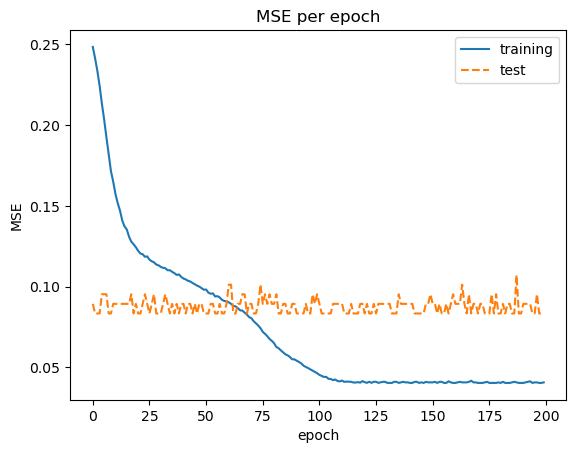

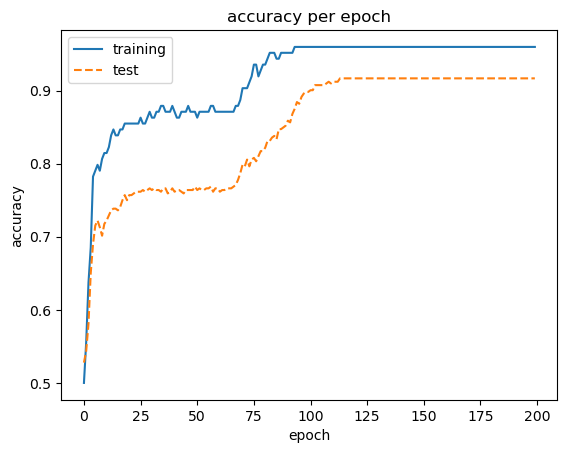

MAX accuracy achieved ON training: 0.9596774193548387
MAX accuracy achieved ON VALIDATION: 0.9166666666666666
MAX MSE train: 0.2484086330138868
MAX MSE validation/test: 0.10714285696676154
RESULTS MONK 2


/Users/giulianogalloppi/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


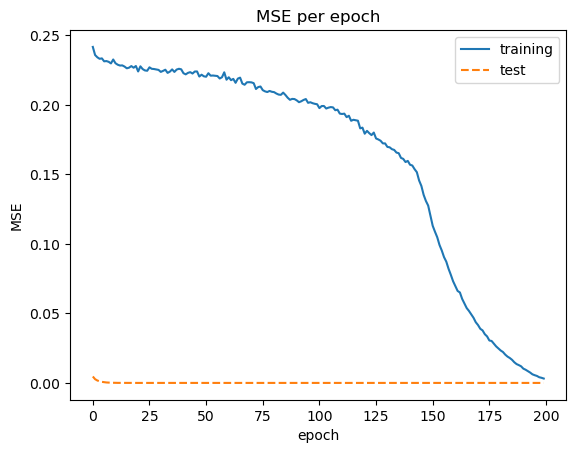

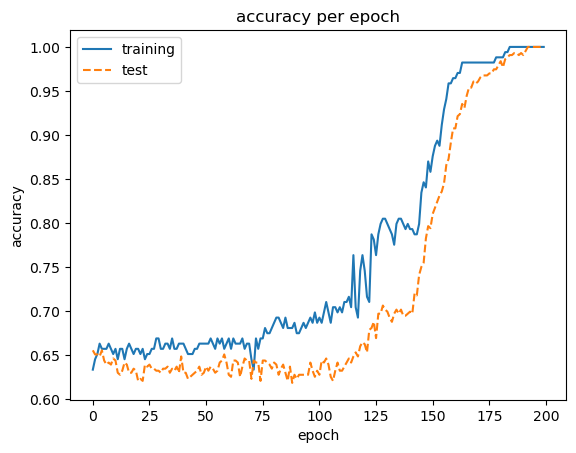

MAX accuracy achieved ON training: 1.0
MAX accuracy achieved ON VALIDATION: 1.0
MAX MSE train: 0.24163112397024616
MAX MSE validation/test: 0.004627175379331068
RESULTS MONK 3


/Users/giulianogalloppi/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


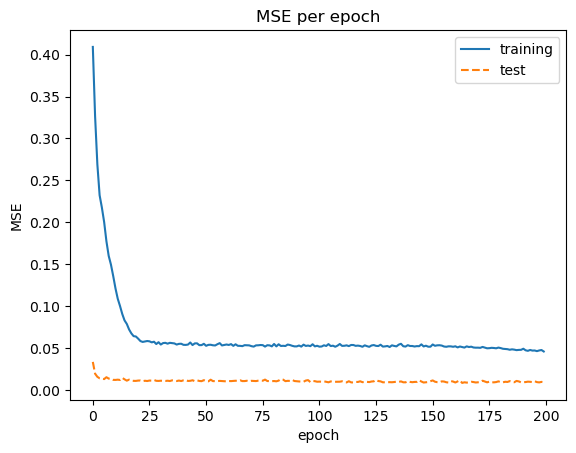

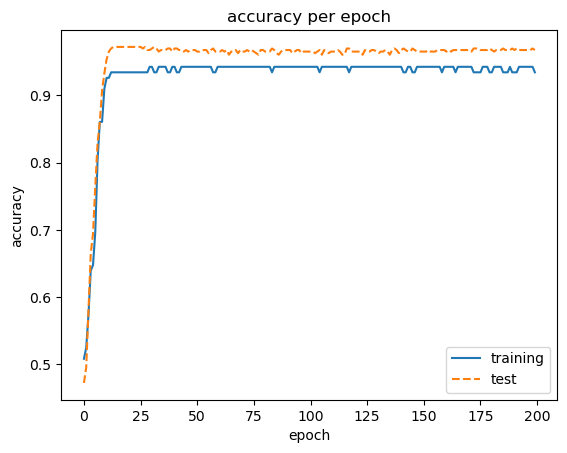

MAX accuracy achieved ON training: 0.9426229508196722
MAX accuracy achieved ON VALIDATION: 0.9722222222222222
MAX MSE train: 0.4091151486166188
MAX MSE validation/test: 0.03376579024242582


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def NN_MONK_solve(monk_n, NN_HP):
    
    df_train = monk_create_df(monk_n)
    df_test = monk_create_df(monk_n, train=False)

    X_train, Y_train = np_monk(df_train, np.float64, np.int32)
    X_test, Y_test = np_monk(df_test, np.float64, np.int32)
    net = NN_BinClassifier(1, NN_HP)

    stats = train_NN_monk(net, X_train, Y_train, X_test, Y_test, 200)
    tr_error, val_error, tr_accuracy, val_accuracy, loss_train = stats


    stats_val = train_NN_monk(net, X_test, Y_test, X_test, Y_test, 200)
    tr_error2, val_error2, tr_accuracy2, val_accuracy2, loss_val = stats_val


    plot_NN_TR_TS(loss_train, loss_val, 'MSE')
    plot_NN_TR_TS(tr_accuracy, val_accuracy, 'accuracy')
    plt.show()

    print('MAX accuracy achieved ON training:', max(tr_accuracy))
    print('MAX accuracy achieved ON VALIDATION:', max(val_accuracy))

    print('MAX MSE train:', max(loss_train))
    print('MAX MSE validation/test:', max(loss_val))





# MONK 1

print("RESULTS MONK 1")

NN_HP = NN_HyperParameters(
    [17, 4],
    lr=0.01,
    beta1=0.9,
    beta2=0.999,
    weight_decay=0,
    mb_size=25,
)

NN_MONK_solve(1, NN_HP)

# MONK 2

print("RESULTS MONK 2")


NN_HP = NN_HyperParameters(
    [17, 4],
    lr=0.01,
    beta1=0.9,
    beta2=0.999,
    weight_decay=0,
    mb_size=25,
)

NN_MONK_solve(2, NN_HP)

# MONK 3

print("RESULTS MONK 3")


NN_HP = NN_HyperParameters(
    [17, 4],
    lr=0.01,
    beta1=0.9,
    beta2=0.999,
    weight_decay=0.003,
    mb_size=25,
)

NN_MONK_solve(3, NN_HP)

# **NN_CUP**

In [6]:
from pyparsing import results
import torch
from torch import nn
from math import ceil, sqrt
import datetime
from pathlib import Path
import toml
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np


class NN_Regressor(NN_module):
    def __init__(self, out_size:int, NN_HP: NN_HyperParameters, Y_scaler):
        super().__init__(out_size, NN_HP)
        # Y scaling
        self.Y_mean = torch.Tensor(Y_scaler.mean_)
        self.Y_scale = torch.Tensor(Y_scaler.scale_)

    def forward(self, x):
        out = self.net(x)
        out = out*self.Y_scale[None,:] + self.Y_mean[None,:]
        return out


def train_NN_cup(model, X_train, Y_train, X_val, Y_val, patience=20, max_epochs=1000, logging=True):
  
    start_time = time.process_time()

    tr_errors, val_errors, losses = [], [] ,[]

    lowest_val_err = 9999999
    since_lowest = 0
    best = None
    converged = False

    mb_size = model.NN_HP.mb_size
    n_samples = X_train.shape[0]

    for _ in range(max_epochs):
        tr_minibatches = epoch_minibatches(mb_size, X_train, Y_train)
        epoch_loss = 0.0
        tr_epoch_err = 0.0

        for inputs, labels in tr_minibatches:
            model.optimizer.zero_grad()

            outputs = model(inputs)
            loss = model.loss_f(outputs, labels)
            loss.backward()
            model.optimizer.step()

            if logging:
                epoch_loss += loss.item()
                tr_epoch_err += MEE(outputs, labels, mean=False)


        val_err = MEE(model(X_val), Y_val)
        
        if logging:
            tr_err = tr_epoch_err / n_samples
            tr_errors.append(tr_err)
            losses.append(epoch_loss * mb_size / n_samples)
            val_errors.append(val_err)
        
        if val_err < (lowest_val_err-lowest_val_err*0.01):
            lowest_val_err = val_err
            since_lowest = 0
            if logging:
                best = model.state_dict()
        else:
            since_lowest += 1
        
        if since_lowest >= patience:
            converged = True
            break

    seconds = time.process_time()-start_time
    
    if logging:
        return tr_errors, val_errors, losses, seconds, best, converged
    else:
        return lowest_val_err, seconds, converged

# CUP EXECUTION-**NN-TRAIN**

{'layers': [10, 15, 15, 15, 15], 'lr': 0.02, 'beta1': 0.9, 'beta2': 0.999, 'weight_decay': 0, 'mb_size': 32}

MEE mean: 0.9851634965768551

MEE std: 0.0

Time (seconds): 1.4397590000000022

Convergence: True


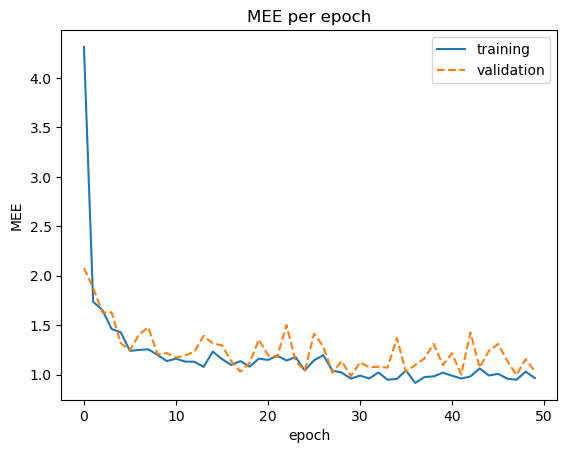

In [8]:
import numpy as np
from torch import Tensor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = load_cup_data(train=True)
X_dev, Y_dev = np_cup_TR(df, test=False)

Y_scaler = StandardScaler()
Y_scaler.fit(Y_dev)

X_dev, Y_dev = Tensor(X_dev), Tensor(Y_dev)

# 20% validation
val_samples = X_dev.shape[0] // 5
X_train = X_dev[:-val_samples]
Y_train = Y_dev[:-val_samples]

X_val = X_dev[-val_samples:]
Y_val = Y_dev[-val_samples:]

NN_HP = NN_HyperParameters(
    [10, 15, 15, 15, 15],
    lr=2E-2,
    beta1=0.9,
    beta2=0.999,
    weight_decay=0,
    mb_size=32,
)
net = NN_Regressor(2,NN_HP, Y_scaler)

stats = train_NN_cup(net, X_train, Y_train, X_val, Y_val, 20,500)

if len(stats) > 4:
    tr_error, val_error, _, seconds, best, converged = stats
    MEE_mean = min(val_error)
    MEE_var = 0.0
    plot_NN_TR_VAL(tr_error, val_error, 'MEE')

else:
    MEE_mean, MEE_var, seconds, converged = stats

print(NN_HP.__dict__)
print(f'\nMEE mean: {MEE_mean}')
print(f'\nMEE std: {MEE_var}')
print(f'\nTime (seconds): {seconds}')
print(f'\nConvergence: {converged}')